# Market Movement Predicition using News Sentiment Analysis
## Anubhav Pawan (22BDS0316)
## Abhijeet Kundu (22BDS0272)
## Ashwin S Narayanan (22BDS0111)

In [2]:
import re
import joblib
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

In [3]:

DATA_PATH = "/Users/anubhavpawan/Downloads/Data.csv"         
SAVE_PIPELINE = "upgraded_pipeline.pkl"
TFIDF_MAX_FEATURES = 5000      # increase to 5000-10000 if you have compute/time
TFIDF_MIN_DF = 3
SVD_COMPONENTS = 70            # reduce to 20 for speed, increase for more info
HGB_MAX_ITER = 500             # lower -> faster; higher -> potentially better
# ---------------------------------------------

# 2) Load and prepare
df = pd.read_csv(DATA_PATH, encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values('Date').reset_index(drop=True)

# identify Top* columns and combine into one "news" field
top_cols = [c for c in df.columns if c.lower().startswith('top')]
df['news'] = df[top_cols].astype(str).apply(lambda row: ' '.join([str(x) for x in row.values if x and str(x).lower() != 'nan']), axis=1)

In [4]:
# 3) Simple offline lexicon (works without external downloads)
positive_lex = {"gain","gains","rise","rises","up","surge","profit","profits","beat","beats","record","strong","growth","buy","bull","rally","optimis","positive","recover","recovery","upgrade","outperform","soar","win","rate cuts","win lawsuit","wins lawsuit"}
negative_lex = {"fall","falls","down","drop","drops","loss","losses","decline","miss","weak","sell","bear","plummet","crash","cut","cuts","downgrade","concern","negative","slump","recession","scandal","fraud","lawsuit","died","rate increase","bankrupt"}

def compute_text_features(row):
    text = str(row['news'])
    tokens = re.findall(r"\w+", text.lower())
    total_words = max(1, len(tokens))
    pos_count = sum(1 for t in tokens if t in positive_lex)
    neg_count = sum(1 for t in tokens if t in negative_lex)
    polarity = (pos_count - neg_count) / total_words
    num_headlines = sum(1 for c in top_cols if str(row[c]).strip().lower() != 'nan' and str(row[c]).strip() != '')
    avg_head_len = np.mean([len(str(row[c])) for c in top_cols if str(row[c]).strip().lower() != 'nan' and str(row[c]).strip() != '']) if num_headlines > 0 else 0
    exclaim_count = text.count('!')
    uppercase_chars = sum(1 for ch in text if ch.isupper())
    uppercase_ratio = uppercase_chars / max(1, len(text))
    unique_word_count = len(set(tokens))
    return {
        'pos_count': pos_count,
        'neg_count': neg_count,
        'polarity': polarity,
        'num_headlines': num_headlines,
        'avg_head_len': avg_head_len,
        'exclaim_count': exclaim_count,
        'uppercase_ratio': uppercase_ratio,
        'unique_word_count': unique_word_count
    }

# compute features
tqdm.pandas(desc="Computing features")
feat_df = df.progress_apply(compute_text_features, axis=1, result_type='expand')
df = pd.concat([df, feat_df], axis=1)

Computing features: 100%|█████████████████| 4101/4101 [00:00<00:00, 4878.99it/s]


/var/folders/cm/mdtk7zh95mbb235lmf6tlqmm0000gn/T/ipykernel_3018/788648536.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=df, palette='viridis')


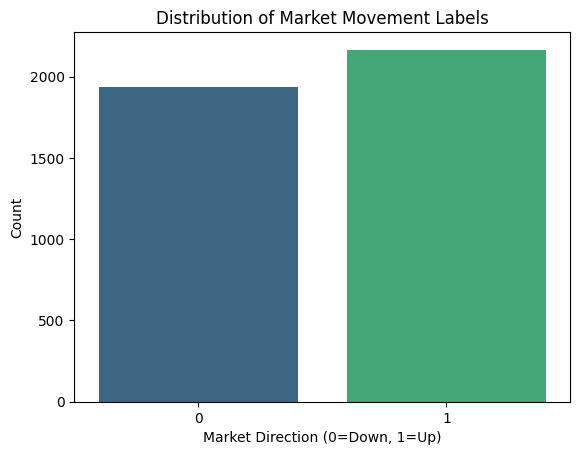

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='Label', data=df, palette='viridis')
plt.title("Distribution of Market Movement Labels")
plt.xlabel("Market Direction (0=Down, 1=Up)")
plt.ylabel("Count")
plt.show()

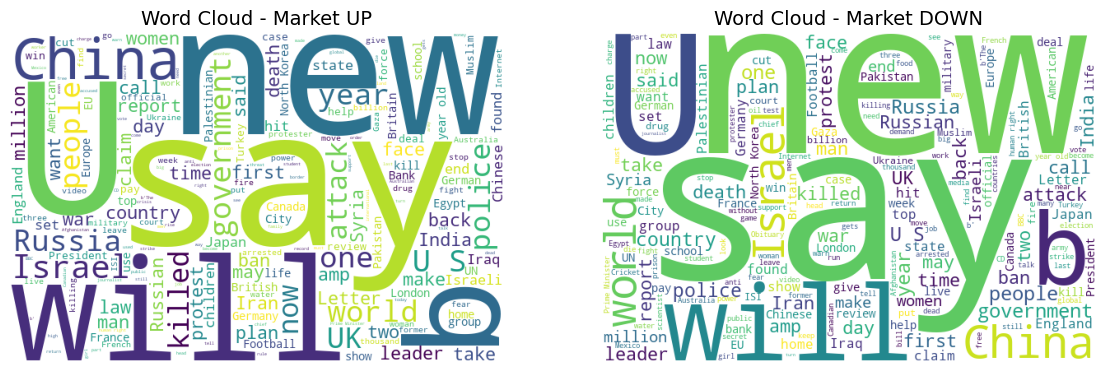

In [6]:
from wordcloud import WordCloud

up_text = " ".join(df[df['Label']==1]['news'])
down_text = " ".join(df[df['Label']==0]['news'])

fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].imshow(WordCloud(width=600, height=400, background_color='white').generate(up_text))
ax[0].set_title("Word Cloud - Market UP", fontsize=14)
ax[0].axis("off")

ax[1].imshow(WordCloud(width=600, height=400, background_color='white').generate(down_text))
ax[1].set_title("Word Cloud - Market DOWN", fontsize=14)
ax[1].axis("off")

plt.show()

In [8]:
# 4) Chronological train/test split
split_idx = int(0.8 * len(df))
train = df.iloc[:split_idx].copy()
test = df.iloc[split_idx:].copy()

X_train_text = train['news'].fillna('')
X_test_text  = test['news'].fillna('')
y_train = train['Label'].astype(int)
y_test  = test['Label'].astype(int)

numeric_cols = ['pos_count','neg_count','polarity','num_headlines','avg_head_len','exclaim_count','uppercase_ratio','unique_word_count']
X_train_num = train[numeric_cols].fillna(0).astype(float)
X_test_num  = test[numeric_cols].fillna(0).astype(float)

In [9]:
# 5) TF-IDF + SVD
tfidf = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, ngram_range=(1,2), stop_words='english', min_df=TFIDF_MIN_DF)
Xtr_tfidf = tfidf.fit_transform(X_train_text)
Xte_tfidf = tfidf.transform(X_test_text)

svd = TruncatedSVD(n_components=SVD_COMPONENTS, random_state=42)
Xtr_svd = svd.fit_transform(Xtr_tfidf)
Xte_svd = svd.transform(Xte_tfidf)

In [10]:
# 6) Combine text components + numeric engineered features
Xtr = np.hstack([Xtr_svd, X_train_num.values])
Xte = np.hstack([Xte_svd, X_test_num.values])

In [11]:
# 7) Scale
scaler = StandardScaler()
Xtr_scaled = scaler.fit_transform(Xtr)
Xte_scaled = scaler.transform(Xte)

In [12]:
# 8) Train improved model (HistGradientBoostingClassifier)
clf = HistGradientBoostingClassifier(random_state=42, max_iter=HGB_MAX_ITER, learning_rate=0.1)
clf.fit(Xtr_scaled, y_train)

HistGradientBoostingClassifier(max_iter=500, random_state=42)

In [13]:
# 9) Evaluate
pred = clf.predict(Xte_scaled)
proba = clf.predict_proba(Xte_scaled)[:,1]

print("=== MODEL METRICS ===")
print("Accuracy:", round(accuracy_score(y_test, pred), 4))
print("Precision:", round(precision_score(y_test, pred), 4))
print("Recall:", round(recall_score(y_test, pred), 4))
print("F1:", round(f1_score(y_test, pred), 4))
try:
    print("ROC AUC:", round(roc_auc_score(y_test, proba), 4))
except:
    print("ROC AUC: could not compute (single-class or other issue).")
print("\nClassification report:\n", classification_report(y_test, pred))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))

=== MODEL METRICS ===
Accuracy: 0.5286
Precision: 0.5491
Recall: 0.6507
F1: 0.5956
ROC AUC: 0.5206

Classification report:
               precision    recall  f1-score   support

           0       0.49      0.39      0.44       383
           1       0.55      0.65      0.60       438

    accuracy                           0.53       821
   macro avg       0.52      0.52      0.52       821
weighted avg       0.52      0.53      0.52       821

Confusion matrix:
 [[149 234]
 [153 285]]


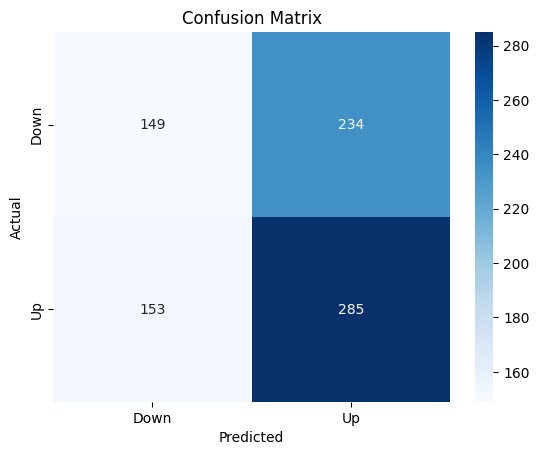

In [14]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Down","Up"], yticklabels=["Down","Up"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


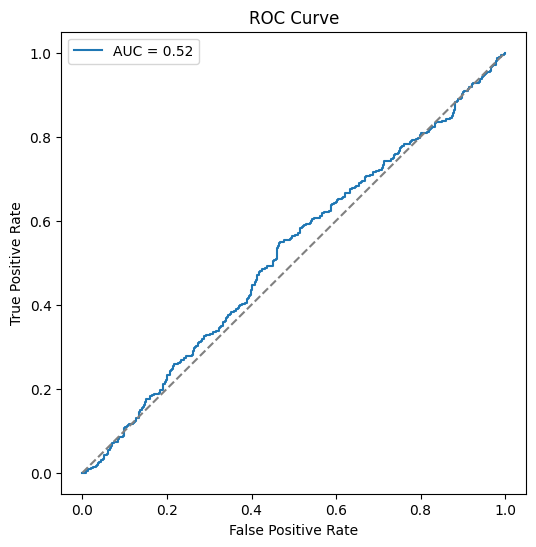

In [19]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, proba)
roc_auc = roc_auc_score(y_test, proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [15]:
# 10) Save pipeline parts so you can predict later
joblib.dump({'tfidf':tfidf, 'svd':svd, 'scaler':scaler, 'clf':clf, 'numeric_cols':numeric_cols, 'top_cols':top_cols}, SAVE_PIPELINE)
print("\nSaved pipeline to:", SAVE_PIPELINE)


Saved pipeline to: upgraded_pipeline.pkl


In [16]:
# --------- 11) Quick helper: use the saved pipeline to predict on n headlines ----------
# Usage example (uncomment when using interactively):
loaded = joblib.load(SAVE_PIPELINE)
tfidf, svd, scaler, clf = loaded['tfidf'], loaded['svd'], loaded['scaler'], loaded['clf']
numeric_cols = loaded['numeric_cols']
def predict_from_headlines(headlines_list):
     combined = " ".join(headlines_list)
     dummy_row = { 'news': combined }
     for c in top_cols:
         dummy_row[c] = combined   # not used for splitting; compute features directly
     feats = compute_text_features(dummy_row)
     X_text = tfidf.transform([combined])
     X_svd = svd.transform(X_text)
     X_num = np.array([[feats[c] for c in numeric_cols]])
     X_all = np.hstack([X_svd, X_num])
     X_all_scaled = scaler.transform(X_all)
     prob_up = clf.predict_proba(X_all_scaled)[0,1]
     pred_label = int(prob_up >= 0.5)
     return pred_label

In [25]:
headlines = input("Enter a headline: ")
label= predict_from_headlines(headlines)
print("The market is likely to go [UP]⬆️." if label==1 else "he market is likely to go [DOWN]⬇️")

Enter a headline:  Good quarterly results.


he market is likely to go [DOWN]⬇️
